In [84]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

SEMILLA_ALEATORIEDAD = 123
np.random.seed(SEMILLA_ALEATORIEDAD)

In [85]:
from pandas import set_option
#from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [86]:
# Crea un gráfico circular con el porcentaje de fotógrafos prefesionales y los que no
def show_loan_distrib(y):
    i=0
    normales = 0
    fotografos = 0
    while (i<len(y)):
        if y[i]==0:
            normales+=1
        else: fotografos+=1
        i+=1

    tamanos = [fotografos, normales]
    etiquetas = [f'Fotógrafos profesionales - {tamanos[0]}', f'Otros usuarios - {tamanos[1]}']

    plt.pie(tamanos, labels=etiquetas, autopct = '%1.1f%%', explode = [0, 0.1])
    plt.show()

In [87]:
# Función para representar la matriz de confusión de las etiquetas

from sklearn.metrics import confusion_matrix

def matrix_confusion_etiq(etiq_manual, etiq_auto):
    cm = confusion_matrix(etiq_manual, etiq_auto) 
    print(cm)
    
    # Para mostrar la información en porcetanjes también
    cm_porcentaje = cm.astype('float')/cm.sum()*100

    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(cm):
        percentage = cm_porcentaje[i, j]
        if i==0 and j==0:
            ax.text(j, i, f'{val} ({percentage:.2f}%)', ha='center', va='center', color = 'white')
        else:
            ax.text(j, i, f'{val} ({percentage:.2f}%)', ha='center', va='center', color = 'black')


    labels = ['No Fotógrafo', 'Fotógrafo']

    ax.set_xlabel('Etiqueta Automática')
    ax.set_ylabel('Etiqueta Manual')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Matriz de Confusión de etiquetados en Instagram')

    plt.show() 

In [88]:
# Función para representar la matriz de confusión de las predicciones

from sklearn.metrics import confusion_matrix

def matrix_confusion_pred(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred) 
    print(cm)
    
    # Para mostrar la información en porcetanjes también
    #cm_porcentaje = cm.astype('float')/cm.sum()*100

    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    for (i, j), val in np.ndenumerate(cm):
        #percentage = cm_porcentaje[i, j]
        fontsize = 12
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, f'{val}', ha='center', va='center', color=color, fontsize=fontsize)

    labels = ['No Fotógrafo', 'Fotógrafo']

    ax.set_xlabel('Predicción')
    ax.set_ylabel('Ground-truth')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Matriz de confusión de la predicción de expertos')

    plt.show() 

In [89]:
# Función que plotea la curva ROC

from sklearn.metrics import roc_curve, auc

def roc_auc(y_test, y_pred_test_proba):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test_proba)
    roc_auc = auc(fpr, tpr)

    #plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

In [90]:
# Función que plotea la curva Precision-Recall

from sklearn.metrics import precision_recall_curve, auc
from numpy import argmax

def pr_auc(y_test, y_pred_test_proba):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test_proba)
    
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    
    pr_auc = auc(recall, precision)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    # plot the roc curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label= f'PR curve (area = {pr_auc:.2f})')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    return thresholds[ix]

In [91]:
# Función que representa en un diagrama de barras las medidas de desempeño en la predicción

# valores es el array con los valores de las métricas que queremos plotear
# ponemos el título del plot como argumento para especificar el caso que estamos ploteando
def show_bars_metrics(valores, titulo):
    nombres = ["Accuracy","Precision","Recall","f1", "ROC-AUC", "AP/PR-AUC"]
    color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # Nombres y valores de las medidas
    #valores = fila_max_manual.values[2:7]

    # Crear una figura y un eje
    fig, ax = plt.subplots()

    # Crear la gráfica de barras
    bars = ax.bar(nombres, valores, color=color, width=0.65)

    # Agregar etiquetas de valores a las barras
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=16)

    # Agregar título y etiquetas de ejes
    ax.set_title(titulo, fontweight='bold', fontsize=20)
    ax.set_xlabel('Medidas', fontsize=12)
    ax.set_ylabel('Valores', fontsize=12)
    plt.yticks(fontsize=14)

    # Mostrar la gráfica
    plt.show()

In [92]:
# Función que dibuja las distribuciones de las características individuales, para cada tipo de etiquetado

# str_etiq es el string del nombre que tiene la variable de clase en el data set df
def show_individual_distrib(df, str_etiq):
    df_prof = df[df[str_etiq] == 1]
    df_noProf = df[df[str_etiq] == 0]

    # Quitamos la columna de respuesta
    df_dist = df_manual.iloc[:,:-1]

    # Calculamos el número de filas y columnas necesarias para organizar los subtrazados
    n_rows = (len(df_dist.columns) + 3) // 4  # Aproximadamente 4 subplots por fila
    n_cols = min(len(df_dist.columns), 4)

    # Ajustamos el tamaño de la figura
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 4 * n_rows))

    # Ploteamos la distribución de cada columna en un subplot separado
    for i, column in enumerate(df_dist.columns):
        ax = axes[i // n_cols, i % n_cols]  # Calculamos la posición del subplot en la cuadrícula
        # Cada diagrama tendrá 40 barras como máximo
        df_prof[column].hist(bins=40, color = 'orange', alpha = 0.5, ax=ax)
        df_noProf[column].hist(bins=40, color = 'blue', alpha = 0.5,ax=ax)
        ax.set_title('{}'.format(column))
        ax.set_xlabel('Valor')
        ax.set_ylabel('Frecuencia')

    # Ajusta automáticamente el diseño de la figura para evitar superposiciones
    plt.tight_layout()
    plt.show()

In [93]:
# Nos devuelve la información sobre la asimetría y la curtosis

# Nos devuelve el skewness y la kurtosis de cada característica
from scipy.stats import skew, kurtosis

def info_asymetry(df):
    skewness = df.apply(skew)
    kurt = df.apply(kurtosis)

    result = pd.DataFrame({
        'Feature': df.columns,
        'Skewness': skewness,
        'Kurtosis': kurt
    }).reset_index(drop=True)
    return result

In [94]:
# Dibuja la matriz de correlación de Pearson entre los atributos

def show_correlation(df):
    correlation_matrix=df.corr().abs()
    sns.set(font_scale = 0.8)

    f, ax = plt.subplots(figsize=(12,12))

    sns.heatmap(correlation_matrix, cmap='YlGnBu', square=True, ax = ax)

    # Rotar las etiquetas del eje x
    plt.xticks(rotation=90)

    f.tight_layout()

In [95]:
# Partición de los datos

def data_partition(df, proportion, str_etiq):
    train_df, test_df = train_test_split(df, test_size=proportion, random_state=SEMILLA_ALEATORIEDAD, stratify=df[str_etiq])

    # Separamos la variable de clase de las demás
    train_manual_x = train_df.loc[:, train_df.columns != str_etiq]
    train_manual_y = train_df.loc[:, str_etiq]

    test_manual_x = test_df.loc[:, test_df.columns != str_etiq]
    test_manual_y = test_df.loc[:, str_etiq]
    
    return [train_manual_x, train_manual_y, test_manual_x, test_manual_y]

In [96]:
# Escalado con StandardScaler

from sklearn.preprocessing import StandardScaler

# Escalado estándar
def std_Scaler_data(train_x, test_x):
    
    scaler = StandardScaler()
    scaler.fit(train_x)
    trainScaled_x = pd.DataFrame(scaler.transform(train_x), columns=train_x.columns, index=train_x.index)
    testScaled_x = pd.DataFrame(scaler.transform(test_x), columns=test_x.columns, index=test_x.index)
    return [trainScaled_x, testScaled_x]

In [97]:
# Escalado con QuantileTransformer

from sklearn.preprocessing import QuantileTransformer

# QuantileTransformer
def qt_Transformer_data(train_x, test_x):
    
    qt = QuantileTransformer(output_distribution='normal')
    qt.fit(train_x)
    trainQT_x = pd.DataFrame(qt.transform(train_x), columns=train_x.columns, index=train_x.index)
    testQT_x = pd.DataFrame(qt.transform(test_x), columns=test_x.columns, index=test_x.index)
    return [trainQT_x, testQT_x]

In [98]:
# Clase que representa el transformador donde se elimina del conjunto las columnas con valores constantes

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class ConstantValueThresholdEliminator(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.columns_to_drop = []

    def fit(self, X, y=None):
        # Calcular el umbral de valores constantes para cada columna
        for column in X.columns:
            most_frequent_value_count = X[column].value_counts().max()
            if most_frequent_value_count / len(X) > self.threshold:
                self.columns_to_drop.append(column)
        return self

    def transform(self, X, y=None):
        # Eliminar las columnas que exceden el umbral de valores constantes
        return X.drop(columns=self.columns_to_drop)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

In [99]:
# Función que hace uso de la clase ConstantValueThresholdEliminator para eliminar columnas constantes

def constant_elimination(train_x, test_x, threshold):
    transformer_cte = ConstantValueThresholdEliminator(threshold=threshold)
    transformer_cte.fit(train_x)
    train_cte_x = transformer_cte.transform(train_x)
    test_cte_x = transformer_cte.transform(test_x)
    return [train_cte_x, test_cte_x]

In [100]:
# Clase que representa el transformador donde se elimina del conjunto las columnas más correlacionadas

from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationThresholdTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_keep_ = None
        self.to_remove = None

    def fit(self, X, y=None):
        # Convertimos a DataFrame si no lo es
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Calculamos la matriz de correlación
        corr_matrix = X.corr().abs()

        # Calculamos la correlación media de cada variable con el resto
        mean_correlation = corr_matrix.mean(axis=0)

        # Identificamos las variables a eliminar basadas en el umbral
        self.to_remove = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    if mean_correlation.iloc[i] > mean_correlation.iloc[j]:
                        self.to_remove.add(corr_matrix.columns[i])
                    else:
                        self.to_remove.add(corr_matrix.columns[j])

        # Guardamos las variables a mantener
        self.features_to_keep_ = [col for col in X.columns if col not in self.to_remove]
        return self
    def get_removed(self):
        return self.to_remove

    def transform(self, X, y=None):
        # Convertimos a DataFrame si no lo es
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Retornamos el dataset con las variables seleccionadas
        return X[self.features_to_keep_]

    def get_support(self):
        # Método para obtener las características seleccionadas
        return self.features_to_keep_

In [101]:
# Función que usa CorrelationThresholdTransformer para eliminar columnas correlacionadas

def corr_elimination(train_x, test_x, threshold):
    transformer_corr = CorrelationThresholdTransformer(threshold=threshold)
    transformer_corr.fit(train_x)
    train_corr_x = transformer_corr.transform(train_x)
    test_corr_x = transformer_corr.transform(test_x)
    #print(transformer_corr.get_removed())
    return [train_corr_x, test_corr_x]

In [102]:
# Función que usa un entrenamiento de Random Forest para seleccionar atributos poco relevantes en el entrenamiento

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

def RelevantInformationEliminator(X, y, threshold=0.01):
    clf = RandomForestClassifier(n_estimators=250,
                              random_state=SEMILLA_ALEATORIEDAD)

    clf.fit(X, y)

    # Plot feature importance
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    #feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    features_eliminated = []
    for index in sorted_idx:
        if feature_importance[index] < threshold:
            features_eliminated.append(X.columns[index])

    return features_eliminated

In [103]:
# Función que elimina los atributos poco relevantes usando la función RelevantInformationEliminator

def low_relevance_elimination(train_x, train_y, test_x, threshold):
    # Seleccionamos las columnas poco relevantes
    features_eliminated = RelevantInformationEliminator(train_x, train_y, threshold)
    print(features_eliminated)
    train_rel_x = train_x.drop(columns = features_eliminated)
    test_rel_x = test_x.drop(columns = features_eliminated)
    return [train_rel_x, test_rel_x]

In [104]:
# Función que aplica PCA al conjunto de datos

from sklearn.decomposition import PCA

def dataset_pca(train_x, test_x, var_explicated):
    pca = PCA(n_components = var_explicated)
    train_pca_x = pca.fit_transform(train_x)
    test_pca_x = pca.transform(test_x)

    train_pca_x = pd.DataFrame(train_pca_x)
    test_pca_x = pd.DataFrame(test_pca_x)
    
    return [train_pca_x, test_pca_x]

In [105]:
# Función que aplica SMOTE al conjunto de datos

from imblearn.over_sampling import SMOTE

def dataset_smote(train_x, train_y, with_sampling_strategy, k_neighbors):
    if with_sampling_strategy and k_neighbors != 0:
        oversample = SMOTE(random_state=SEMILLA_ALEATORIEDAD, sampling_strategy=0.5, k_neighbors=k_neighbors)
    elif with_sampling_strategy:
        oversample = SMOTE(random_state=SEMILLA_ALEATORIEDAD, sampling_strategy=0.5)
    else:
        oversample = SMOTE(random_state=SEMILLA_ALEATORIEDAD)
        
    smote_x, smote_y = oversample.fit_resample(train_x, train_y)
    return [smote_x, smote_y]

In [106]:
# Función que aplica el bloque de preprocesamiento al conjunto de datos

def dataset_bloque(train_x, train_y, test_x, threshold_cte, threshold_corr,
                  threshold_relevance):
    train_cte_x, test_cte_x = constant_elimination(train_x, test_x, threshold_cte)
    
    train_corr_cte_x, test_corr_cte_x = corr_elimination(train_cte_x, test_cte_x, threshold_corr)
    
    train_bloque_x, test_bloque_x = low_relevance_elimination(train_corr_cte_x, train_y, test_corr_cte_x, threshold_relevance)
    
    return [train_bloque_x, test_bloque_x]

In [107]:
# Función que crea la lista de conjuntos de datos con preprocesamientos distintos

def conjuntos_preprocesamiento(train_x, test_x, train_y, test_y, with_pca=False,
                              with_smote=False, threshold_cte = 0.9, threshold_corr=0.9,
                              threshold_relevance = 0.01, sampling_strategy = False, k_neighbors = 0,
                              var_explicated = 0.9):
    conjuntos = []
    #conjuntos_aux = []
    
    trainScaled_x, testScaled_x = std_Scaler_data(train_x, test_x)
    conjuntos.append(["std", trainScaled_x, train_y, testScaled_x, test_y])
    
    trainScaled_bloque_x, testScaled_bloque_x = dataset_bloque(trainScaled_x, train_y, testScaled_x, threshold_cte,
                                                           threshold_corr, threshold_relevance)
    
    conjuntos.append(["std_bloque", trainScaled_bloque_x, train_y, testScaled_bloque_x, test_y])
    
    #conjuntos_aux.append(["std_bloque", trainScaled_bloque_x, train_y, testScaled_bloque_x, test_y])
    
    trainQT_x, testQT_x = qt_Transformer_data(train_x, test_x)
    conjuntos.append(["qt", trainQT_x, train_y, testQT_x, test_y])
    
    trainQT_bloque_x, testQT_bloque_x = dataset_bloque(trainQT_x, train_y, testQT_x, threshold_cte,
                                                           threshold_corr, threshold_relevance)
    
    conjuntos.append(["qt_bloque", trainQT_bloque_x, train_y, testQT_bloque_x, test_y])
    
    #conjuntos_aux.append(["qt_bloque", trainQT_bloque_x, train_y, testQT_bloque_x, test_y])
    
    if with_pca and with_smote:
        train_std_pca_x, test_std_pca_x = dataset_pca(trainScaled_bloque_x, testScaled_bloque_x, var_explicated)
        conjuntos.append(["std_bloque_pca", train_std_pca_x, train_y, test_std_pca_x, test_y])
        
        train_qt_pca_x, test_qt_pca_x = dataset_pca(trainQT_bloque_x, testQT_bloque_x, var_explicated)
        conjuntos.append(["qt_bloque_pca", train_qt_pca_x, train_y, test_qt_pca_x, test_y])
        
        # Aplicamos SMOTE con PCA
        smote_std_pca_x, smote_std_pca_y = dataset_smote(train_std_pca_x, train_y, sampling_strategy, k_neighbors)
        conjuntos.append(["std_bloque_pca_smote", smote_std_pca_x, smote_std_pca_y, test_std_pca_x, test_y])
        
        smote_qt_pca_x, smote_qt_pca_y = dataset_smote(train_qt_pca_x, train_y, sampling_strategy, k_neighbors)
        conjuntos.append(["qt_bloque_pca_smote", smote_qt_pca_x, smote_qt_pca_y, test_qt_pca_x, test_y])

        # Aplicamos SMOTE sin PCA
        smote_std_x, smote_std_y = dataset_smote(trainScaled_bloque_x, train_y, sampling_strategy, k_neighbors)
        conjuntos.append(["std_bloque_smote", smote_std_x, smote_std_y, testScaled_bloque_x, test_y])
        
        smote_qt_x, smote_qt_y = dataset_smote(trainQT_bloque_x, train_y, sampling_strategy, k_neighbors)
        conjuntos.append(["qt_bloque_smote", smote_qt_x, smote_qt_y, testQT_bloque_x, test_y])
        
    elif with_smote:
        smote_std_x, smote_std_y = dataset_smote(trainScaled_bloque_x, train_y, sampling_strategy, k_neighbors)
        conjuntos.append(["std_bloque_smote", smote_std_x, smote_std_y, testScaled_bloque_x, test_y])
        
        smote_qt_x, smote_qt_y = dataset_smote(trainQT_bloque_x, train_y, sampling_strategy, k_neighbors)
        conjuntos.append(["qt_bloque_smote", smote_qt_x, smote_qt_y, testQT_bloque_x, test_y])
    elif with_pca:
        train_std_pca_x, test_std_pca_x = dataset_pca(trainScaled_bloque_x, testScaled_bloque_x, var_explicated)
        conjuntos.append(["std_bloque_pca", train_std_pca_x, train_y, test_std_pca_x, test_y])
        
        train_qt_pca_x, test_qt_pca_x = dataset_pca(trainQT_bloque_x, testQT_bloque_x, var_explicated)
        conjuntos.append(["qt_bloque_pca", train_qt_pca_x, train_y, test_qt_pca_x, test_y])
    
        
    return conjuntos

In [108]:
# Función que establece los algoritmos de aprendizaje supervisado a usar

# Spot-Check Algorithms
def ImbGetBasedModelDef():
    basedModels = []
    # Lineales (estoy pensando en usar LR en lugar de esta)
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    # No lineales
    basedModels.append(('SVM'  , SVC(probability=True, class_weight='balanced')))
    # Ensamblados
    basedModels.append(('RF'   , RandomForestClassifier(class_weight='balanced')))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    
    return basedModels

In [109]:
# Función que aplica el bucle general de selección de modelos a partir de una búsqueda de hiperparámetros, para cada combinación
# de algoritmo y preprocesado

from sklearn import metrics

# El scoring por defecto es roc-auc, pero en clases desbalanceadas deberemos poner "average_precision"
def bucle_proceso_general(conjuntos,  grids, scoring = "roc_auc"):
    resultados = pd.DataFrame(columns = ["modelo", "conjunto", "accuracy", "precision", "recall", "f1", "AUC-ROC","AP/PR-AUC"])
    
    # Todo lo que nos aporta información sobre la predicción
    best_models = []
    best_hyperparams = []
    matrices_confusion = []
    y_pred_list = []
    y_pred_proba_list = []
    
    imbModels = ImbGetBasedModelDef()
    
    i = 0
    for model_name, model in imbModels:
        for cjto_name, x_train, y_train, x_test, y_test in conjuntos:

            grid_search = GridSearchCV(model, scoring=scoring, n_jobs= -1, verbose = 1, param_grid=grids[i], cv=5)
            grid_search.fit(x_train, y_train)
            
            best_model = grid_search.best_estimator_
            best_models.append([model_name+"-"+cjto_name, best_model])
            
            best_params = grid_search.best_params_
            best_hyperparams.append([model_name+"-"+cjto_name, best_params])

            y_pred = best_model.predict(x_test)
            y_pred_list.append([model_name+"-"+cjto_name, y_pred])
            
            y_pred_proba = best_model.predict_proba(x_test)[:,-1]
            y_pred_proba_list.append([model_name+"-"+cjto_name, y_pred_proba])

            print(model_name + " " + cjto_name)
            print()
            
            cm =metrics.confusion_matrix(y_test, y_pred)
            print(cm)
            
            matrices_confusion.append([model_name+"-"+cjto_name, cm])
            print(metrics.classification_report(y_test,y_pred))

            roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
            print("ROC-AUC", round(roc_auc, 4))
            
            average_precision = metrics.average_precision_score(y_test, y_pred_proba)
            print("AP/PR-AUC: ",round(average_precision,4))

            # Calcular las métricas de rendimiento
            accuracy = metrics.accuracy_score(y_test, y_pred)
            precision = metrics.precision_score(y_test, y_pred)
            recall = metrics.recall_score(y_test, y_pred)
            f1 = metrics.f1_score(y_test, y_pred)
            resultados.loc[len(resultados.index)] = [model_name, cjto_name, accuracy, precision, recall, f1, roc_auc, average_precision]

        i+=1
        
    return [resultados, best_models, best_hyperparams, matrices_confusion, y_pred_list, y_pred_proba_list]

In [110]:
# Función auxiliar que nos ayuda a encontrar el mejor modelo de la lista de modelos devuelta por el proceso de la función bucle_proceso_general

# nombre_buscado es el nombre de la mejor combinacion de preprocesado y algoritmo que buscamos en la
# lista de mejores modelos para cada combinación
def busca_tupla_nombre(nombre_buscado, best_models):
    tupla = None
    for nombre, params in best_hyperparams:
        if nombre == nombre_buscado:
            tupla = (nombre, params)
            break
    return tupla

In [111]:
# Función que devuelve el mejor resultado de la lista de resultados de la función bucle_proceso_general


# resultados es el dataframe con todos los resultados de cada combinación de preprocesado y algoritmo
# scoring es la columna que comparamos para sacar el mejor
def mejor_resultado(resultados, scoring):
    idx_max = resultados[scoring].idxmax()
    fila_max = resultados.loc[idx_max]
    print(fila_max)
    nombre_buscado = fila_max['modelo']+"-"+fila_max['conjunto']
    print(nombre_buscado)
    return [fila_max, nombre_buscado]

In [112]:
# Función que guarda de la lista de elementos obtenidos por la función bucle_proceso_general, aquel que nos haya dado los mejores resultados

def save_best(lista, file, nombre_buscado):
    tupla = None
    for nombre, elemento in lista:
        if nombre == nombre_buscado:
            tupla = (nombre, elemento)
            break

    joblib.dump(tupla, file)
    return tupla

In [113]:
def find_element(nombre, lista):
    for nombre_element, element in lista:
        if nombre_element == nombre:
            element_return = element
            break
    return element_return

In [114]:
def find_preproc(nombre, conjunto):
    for nombre_aux, train_x, train_y, test_x, test_y in conjunto:
        if nombre == nombre_aux:
            tupla = [nombre_aux, train_x, train_y, test_x, test_y]
            break
    return tupla

In [115]:
# Función que devuelve las medidas de desempeño a partir de un modelo Dummy, que depende del parámetros strategy

from sklearn.dummy import DummyClassifier

def DummyResults(train_x, train_y, test_x, test_y, strategy="most_frequent"):
    # Crear el modelo dummy
    dummy_clf = DummyClassifier(strategy=strategy)

    dummy_clf.fit(train_x, train_y)

    # Hacer predicciones con el modelo dummy
    y_pred_dummy = dummy_clf.predict(test_x)
    y_pred_proba_dummy = dummy_clf.predict_proba(test_x)[:,-1]
    cm =metrics.confusion_matrix(test_y, y_pred_dummy)
    print(cm)

    print(metrics.classification_report(test_y,y_pred_dummy))
    
    # Calcular métricas de rendimiento
    f1 = metrics.f1_score(test_y, y_pred_dummy)
    accuracy = metrics.accuracy_score(test_y, y_pred_dummy)
    precision = metrics.precision_score(test_y, y_pred_dummy)
    recall = metrics.recall_score(test_y, y_pred_dummy)

    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    roc_auc = metrics.roc_auc_score(test_y, y_pred_proba_dummy)
    print("ROC-AUC", round(roc_auc, 4))
    
    average_precision = metrics.average_precision_score(test_y, y_pred_proba_dummy)
    print("AP/PR-AUC: ",round(average_precision,4))

Para obtener el dataset con los datos para la replicación de los experimentos, consultar el README del repositorio.

In [ ]:
DATASET_MANUAL_FILE = 
DATASET_AUTO_FILE =

# Análisis previo

In [129]:
df_manual = pd.read_csv(DATASET_MANUAL_FILE)
df_manual = df_manual.astype(float)
df_manual

,followers,followees,numberOfPosts,imagePorcentage,sidecarPorcentage,videoPorcentage,isBusiness,isProfessional,hasLink,hideLikes,...,cEntropy,captionLength,captionSubjectivity,captionPolarity,captionDifficultWords,captionSecondsToRead,captionEntropy,captionAvgHashtags,captionVarHashtags,Photographer
0,4604.0,281.0,355.0,62.50,12.50,25.00,0.0,1.0,1.0,0.0,...,3.164,244.462,0.0,0.0,14.192,10.402,4.258,17.346,130.303,0.0
1,922.0,1573.0,193.0,3.23,96.77,0.00,1.0,1.0,1.0,0.0,...,3.793,585.500,1.0,1.0,28.133,24.653,4.605,28.233,17.046,0.0
2,598.0,630.0,650.0,100.00,0.00,0.00,0.0,0.0,0.0,1.0,...,4.239,667.133,0.0,0.0,33.333,28.431,4.672,29.833,0.339,1.0
3,276.0,302.0,170.0,70.97,25.81,3.23,0.0,1.0,0.0,0.0,...,3.577,394.733,0.0,0.0,14.533,16.908,4.591,24.800,29.893,0.0
4,821.0,502.0,1148.0,46.67,53.33,0.00,0.0,0.0,0.0,0.0,...,4.030,339.667,0.0,0.0,18.533,14.520,4.346,25.500,43.050,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,139.0,203.0,54.0,18.92,62.16,18.92,0.0,1.0,1.0,0.0,...,3.702,142.000,0.0,0.0,7.900,5.836,4.313,5.667,42.622,0.0
178,1180.0,773.0,840.0,46.67,53.33,0.00,1.0,1.0,0.0,1.0,...,3.803,327.667,0.0,0.0,18.100,13.697,4.557,22.800,1.293,1.0
179,191.0,94.0,590.0,46.67,53.33,0.00,0.0,0.0,1.0,0.0,...,4.309,552.567,0.0,0.0,18.100,21.717,4.926,18.600,9.707,0.0
180,3060.0,999.0,291.0,87.88,3.03,9.09,0.0,1.0,0.0,0.0,...,4.077,773.333,1.0,1.0,33.000,31.768,4.429,27.333,10.489,0.0


In [130]:
df_aut = pd.read_csv(DATASET_AUTO_FILE)
df_aut = df_aut.astype(float)
df_aut

,followers,followees,numberOfPosts,imagePorcentage,sidecarPorcentage,videoPorcentage,isBusiness,isProfessional,hasLink,hideLikes,...,cEntropy,captionLength,captionSubjectivity,captionPolarity,captionDifficultWords,captionSecondsToRead,captionEntropy,captionAvgHashtags,captionVarHashtags,Photographer
0,4604.0,281.0,355.0,62.50,12.50,25.00,0.0,1.0,1.0,0.0,...,3.164,244.462,0.0,0.0,14.192,10.402,4.258,17.346,130.303,1.0
1,922.0,1573.0,193.0,3.23,96.77,0.00,1.0,1.0,1.0,0.0,...,3.793,585.500,1.0,1.0,28.133,24.653,4.605,28.233,17.046,1.0
2,598.0,630.0,650.0,100.00,0.00,0.00,0.0,0.0,0.0,1.0,...,4.239,667.133,0.0,0.0,33.333,28.431,4.672,29.833,0.339,0.0
3,276.0,302.0,170.0,70.97,25.81,3.23,0.0,1.0,0.0,0.0,...,3.577,394.733,0.0,0.0,14.533,16.908,4.591,24.800,29.893,0.0
4,821.0,502.0,1148.0,46.67,53.33,0.00,0.0,0.0,0.0,0.0,...,4.030,339.667,0.0,0.0,18.533,14.520,4.346,25.500,43.050,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,139.0,203.0,54.0,18.92,62.16,18.92,0.0,1.0,1.0,0.0,...,3.702,142.000,0.0,0.0,7.900,5.836,4.313,5.667,42.622,1.0
178,1180.0,773.0,840.0,46.67,53.33,0.00,1.0,1.0,0.0,1.0,...,3.803,327.667,0.0,0.0,18.100,13.697,4.557,22.800,1.293,1.0
179,191.0,94.0,590.0,46.67,53.33,0.00,0.0,0.0,1.0,0.0,...,4.309,552.567,0.0,0.0,18.100,21.717,4.926,18.600,9.707,0.0
180,3060.0,999.0,291.0,87.88,3.03,9.09,0.0,1.0,0.0,0.0,...,4.077,773.333,1.0,1.0,33.000,31.768,4.429,27.333,10.489,1.0


In [131]:
# Contamos el número de usuarios DELETED
num_deleted = df_manual['Photographer'].value_counts().get('DELETED', 0)
print(num_deleted)

0


In [132]:
# Contamos el número de usuarios DELETED
num_deleted = df_aut['Photographer'].value_counts().get('DELETED', 0)
print(num_deleted)

0


In [133]:
# Calculamos el número de valores faltantes por columna
na_por_columna = df_manual.isna().sum()

# Filtramos las columnas con valores faltantes
columnas_con_na = na_por_columna[na_por_columna > 0]

# Mostramos las columnas con valores faltantes y el número de NA
for columna, na_count in columnas_con_na.items():
    print("Columna: "+str(columna)+ " Número de NA: "+str(na_count))

In [134]:
# Calculamos el número de valores faltantes por columna
na_por_columna = df_aut.isna().sum()

# Filtramos las columnas con valores faltantes
columnas_con_na = na_por_columna[na_por_columna > 0]

# Mostramos las columnas con valores faltantes y el número de NA
for columna, na_count in columnas_con_na.items():
    print("Columna: "+str(columna)+ " Número de NA: "+str(na_count))

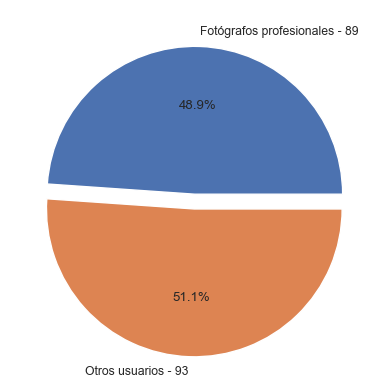

In [135]:
show_loan_distrib(df_manual['Photographer'])

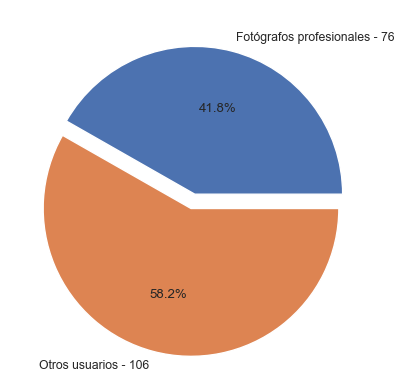

In [136]:
show_loan_distrib(df_aut['Photographer'])

In [137]:
from sklearn.metrics import cohen_kappa_score
ck_score = cohen_kappa_score(df_manual['Photographer'], df_aut['Photographer'])
print(ck_score)

0.3272330626590716


[[69 24]
 [37 52]]


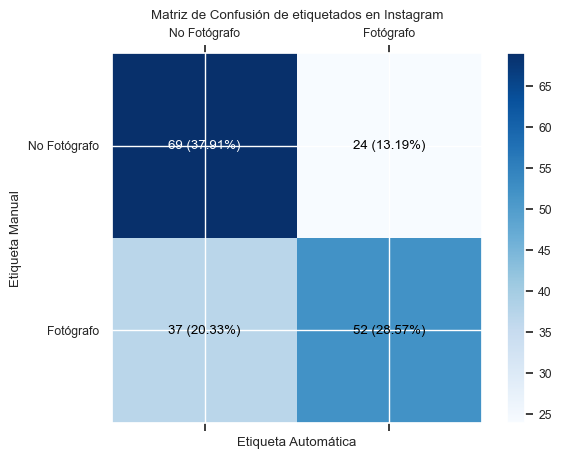

In [138]:
matrix_confusion_etiq(df_manual['Photographer'], df_aut['Photographer'])

In [139]:
data_features = df_manual.loc[:, df_manual.columns != "Photographer"]

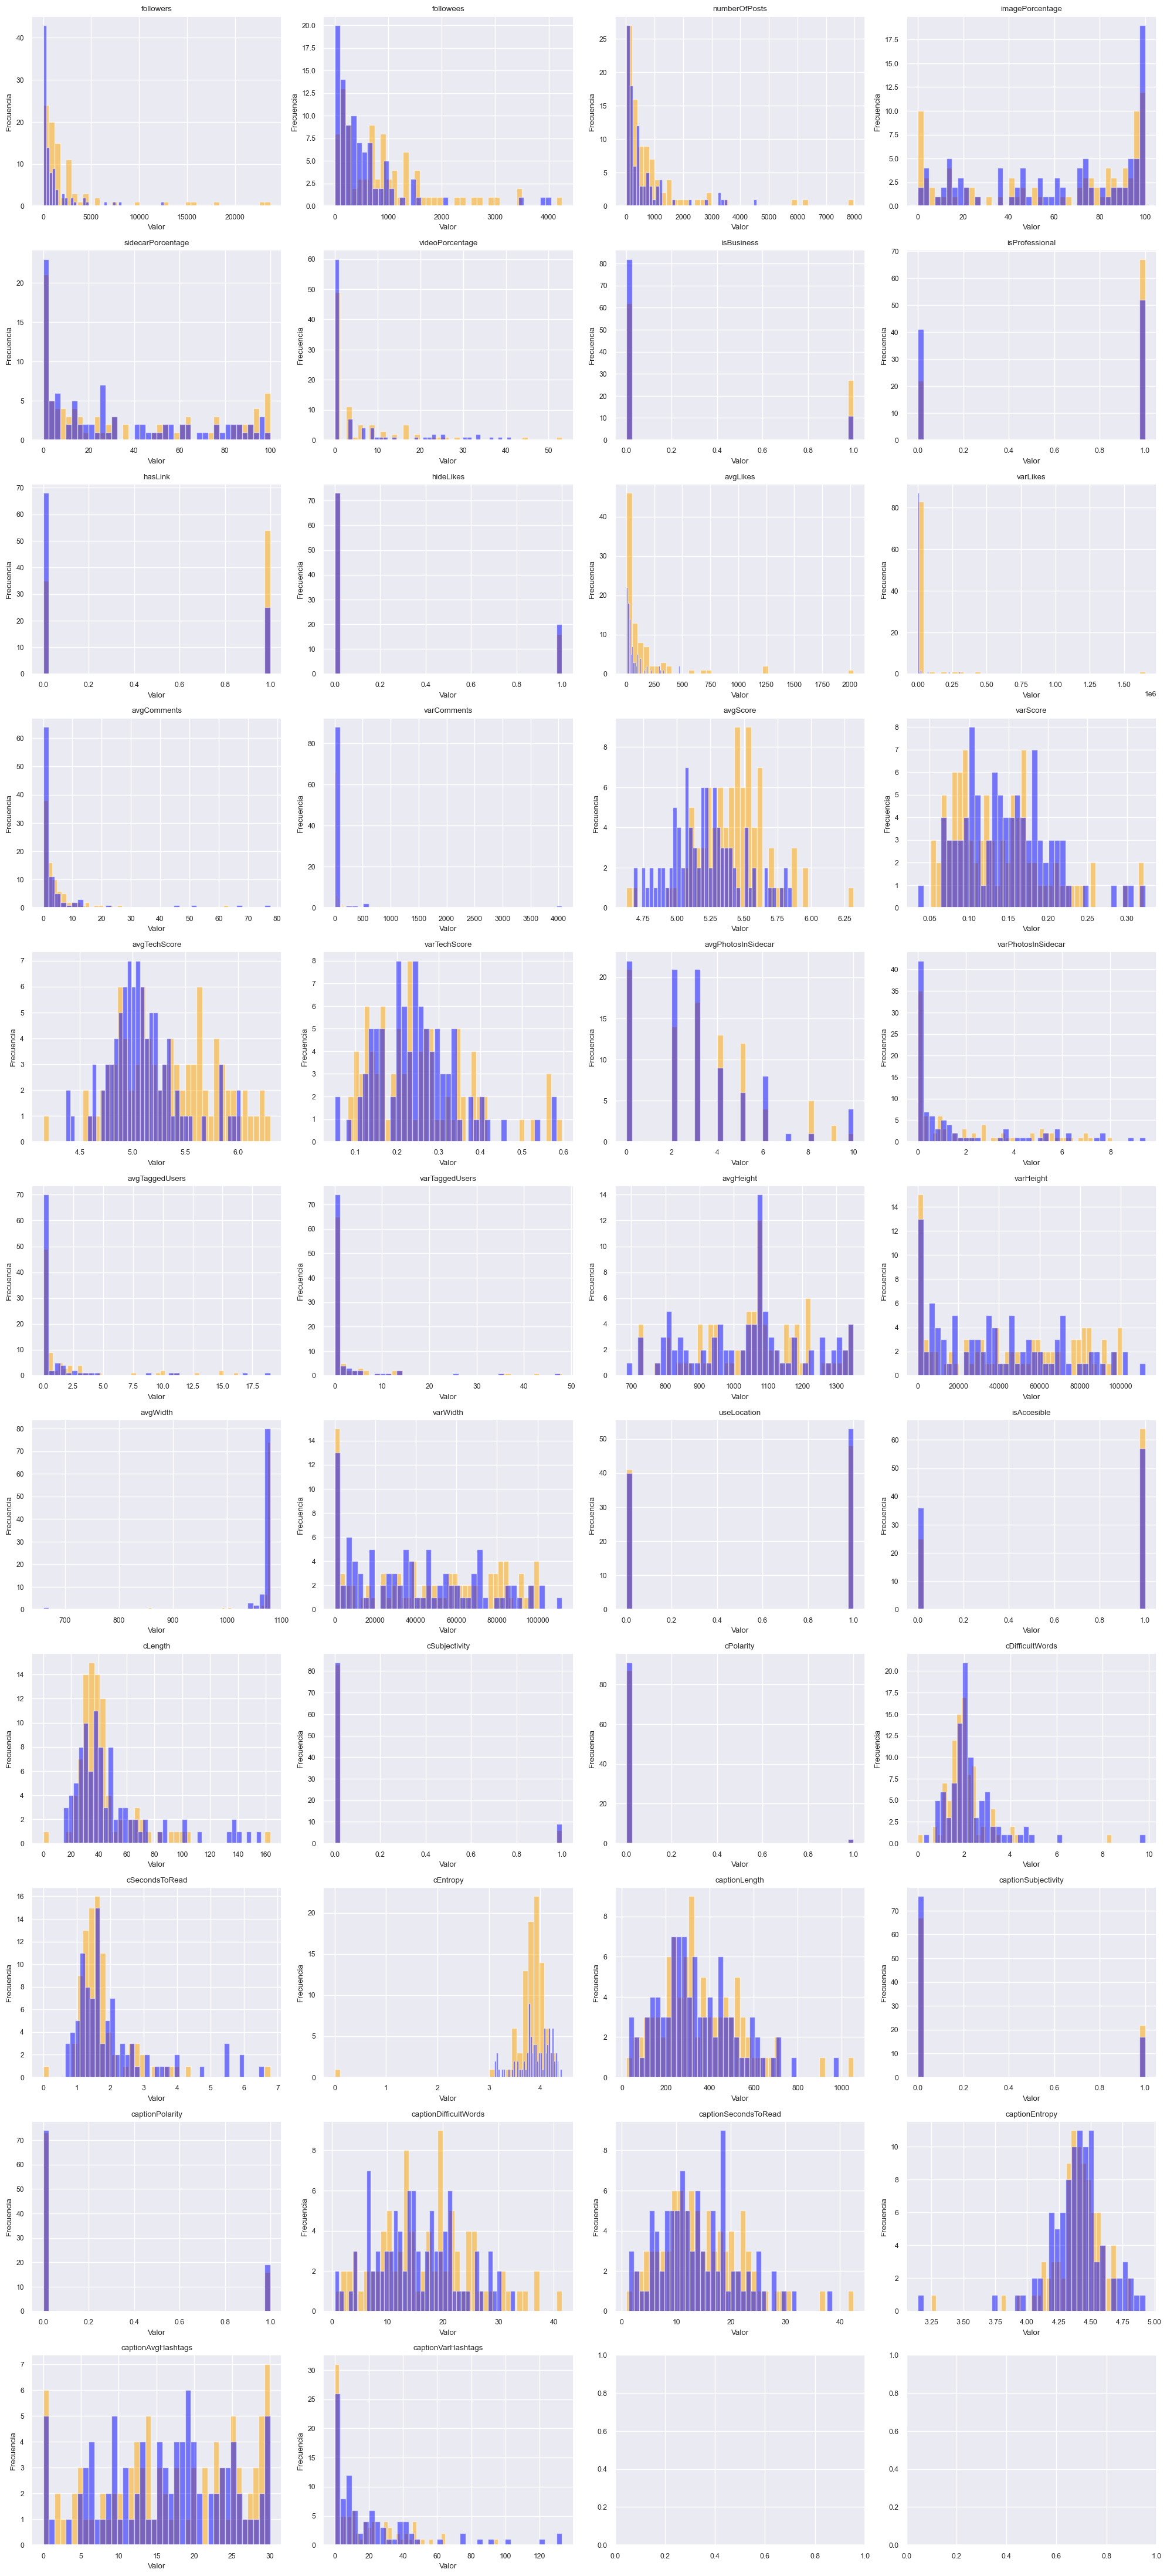

In [140]:
show_individual_distrib(df_manual, 'Photographer')

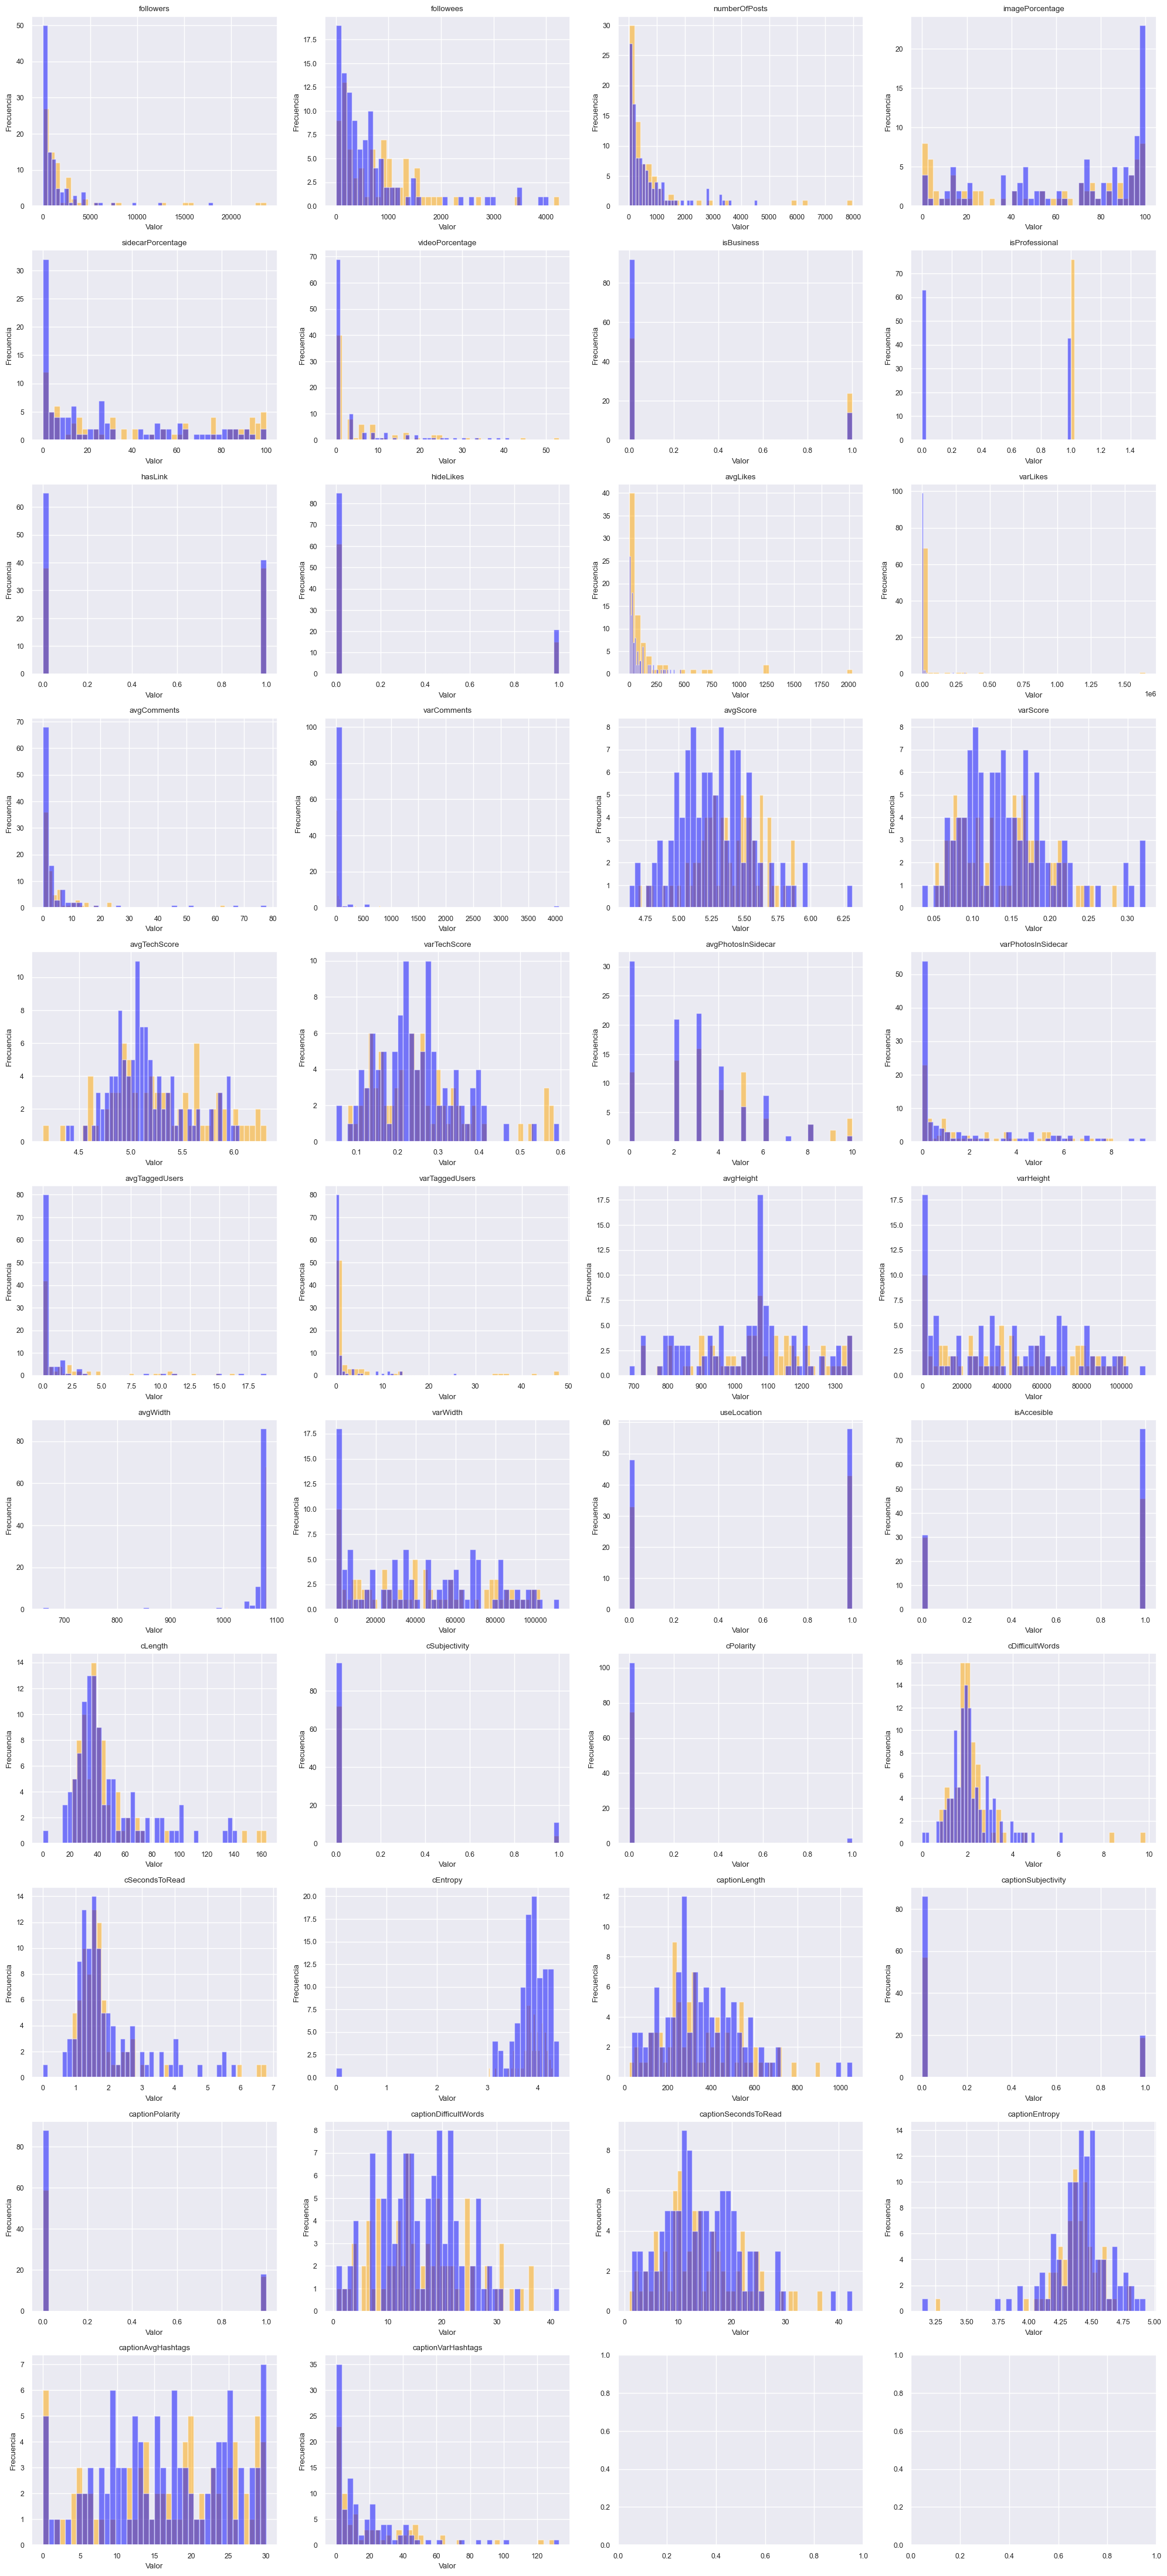

In [141]:
show_individual_distrib(df_aut, 'Photographer')

In [142]:
asymetry = info_asymetry(data_features)
pd.set_option('display.max_rows', None)
asymetry

,Feature,Skewness,Kurtosis
0,followers,3.929220,17.285880
1,followees,2.138715,4.995582
2,numberOfPosts,3.404193,14.367303
3,imagePorcentage,-0.439632,-1.330690
4,sidecarPorcentage,0.659812,-1.065014
5,videoPorcentage,2.184365,4.627146
6,isBusiness,1.432956,0.053363
7,isProfessional,-0.646762,-1.581699
8,hasLink,0.266060,-1.929212
9,hideLikes,1.517277,0.302131


In [143]:
pd.reset_option('display.max_rows')

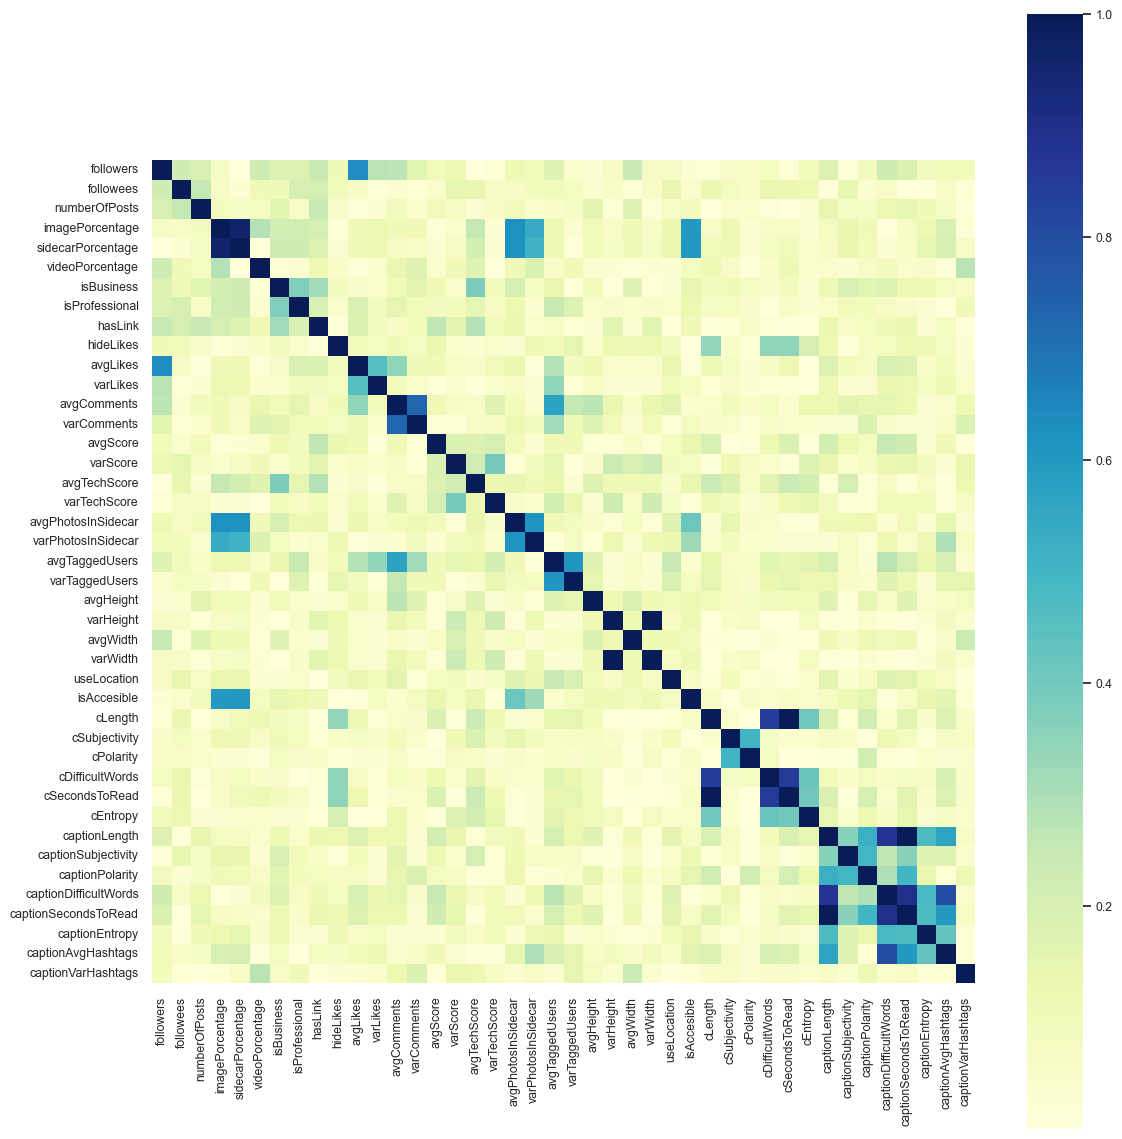

In [144]:
show_correlation(data_features)

Grid de hiperparámetros a utilizar

In [ ]:
grids = [
    {# LDA
        'solver' : ['svd', 'lsqr'],
        'n_components' : [None] + [1, 2, 5, 8, 13, 21, 34, 55],
        'store_covariance' : [True, False],
        'tol' : [1e-2, 1e-3, 1e-5, 1e-7, 1e-9, 1e-11]
    },
    {# SVM
        'C': [1,10,100,1000],
        'gamma': [1,0.1,0.001,0.0001], 
        'kernel': ['linear','rbf']
    },
    {# RF
        'bootstrap': [True, False],
         'max_depth': [10, 50, 100, None],
         'max_features': ['auto', 'sqrt'],
        'criterion' :['gini', 'entropy'],
         'n_estimators': [200, 400, 600, 800]
    },
    {# GBM
        'n_estimators': [100, 200, 500],  # Número de árboles
        'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje
        'max_depth': [3, 5, 7],  # Profundidad máxima de los árboles
        'max_features': ['auto', 'sqrt', 'log2']  # Fracción de características consideradas para dividir en cada nodo

    }
]

# Etiqueta manual

In [ ]:
df_manual = pd.read_csv(DATASET_MANUAL_FILE)
df_manual

In [ ]:
train_manual_x, train_manual_y, test_manual_x, test_manual_y = data_partition(df_manual, 0.3, 'Photographer')

In [ ]:
conjuntos_manual = conjuntos_preprocesamiento(train_manual_x, test_manual_x, train_manual_y, 
                                              test_manual_y, with_pca=True, with_smote=False)
len(conjuntos_manual)

In [ ]:
for nombre, train_aux_x, train_aux_y, test_aux_x, test_aux_y in conjuntos_manual:
    print(nombre)
    print(str(len(train_aux_x.columns)) + ", " + str(len(test_aux_x.columns)) )

In [ ]:
import os

if (not os.path.exists(f"resultados_manual.csv")):
    resultados_manual, best_models_manual, best_hyperparams_manual, matrices_confusion_manual, y_pred_list_manual, y_pred_proba_list_manual = bucle_proceso_general(conjuntos_manual,  grids, scoring = "roc_auc")
    resultados_manual.to_csv("resultados_manual.csv", index = False)
    
    fila_manual, nombre_manual = mejor_resultado(resultados_manual, "AP/PR-AUC")
    
    best_model_manual = save_best(best_models_manual, 'mejor_modelo_manual.joblib', nombre_manual)
    best_params_manual = save_best(best_hyperparams_manual, 'mejor_params_manual.joblib', nombre_manual)
    best_matrix_manual = save_best(matrices_confusion_manual, 'mejor_matrix_manual.joblib', nombre_manual)
    best_ypred_manual = save_best(y_pred_list_manual, 'mejor_ypred_manual.joblib', nombre_manual)
    best_ypred_proba_manual = save_best(y_pred_proba_list_manual, 'mejor_ypred_proba_manual.joblib', nombre_manual)
else:
    resultados_manual = pd.read_csv("resultados_manual.csv")
    
    fila_manual, nombre_manual = mejor_resultado(resultados_manual, "AP/PR-AUC")
    
    best_model_manual = joblib.load('mejor_modelo_manual.joblib')
    best_params_manual = joblib.load('mejor_params_manual.joblib')
    best_matrix_manual = joblib.load('mejor_matrix_manual.joblib')
    best_ypred_manual = joblib.load('mejor_ypred_manual.joblib')
    best_ypred_proba_manual = joblib.load('mejor_ypred_proba_manual.joblib')

In [ ]:
resultados_manual

In [ ]:
fila_manual

In [ ]:
DummyResults(train_manual_x, train_manual_y, test_manual_x, test_manual_y)

In [ ]:
DummyResults(train_manual_x, train_manual_y, test_manual_x, test_manual_y, "stratified")

In [ ]:
show_bars_metrics(fila_manual.values[2:8], "Medidas de Desempeño para Caso Manual")

In [ ]:
matrix_confusion_pred(test_manual_y, best_ypred_manual[1])

In [ ]:
y_pred_proba_manual = best_ypred_proba_manual[1]

In [ ]:
roc_auc(test_manual_y, y_pred_proba_manual)

In [ ]:
threshold_manual = pr_auc(test_manual_y, y_pred_proba_manual)

In [ ]:
# Convertir probabilidades a etiquetas binarias usando el umbral
y_pred_threshold = (y_pred_proba_manual >= threshold_manual).astype(int)

# Calcular métricas de rendimiento
f1 = metrics.f1_score(test_manual_y, y_pred_threshold)
accuracy = metrics.accuracy_score(test_manual_y, y_pred_threshold)
precision = metrics.precision_score(test_manual_y, y_pred_threshold)
recall = metrics.recall_score(test_manual_y, y_pred_threshold)

cm =metrics.confusion_matrix(test_manual_y, y_pred_threshold)
print(cm)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Etiqueta computacional

In [ ]:
df_aut = pd.read_csv(DATASET_AUTO_FILE)
df_aut

In [ ]:
train_auto_x, train_auto_y, test_auto_x, test_auto_y = data_partition(df_aut, 0.3, 'Photographer')

In [ ]:
train_auto_x = train_auto_x.drop(columns='isProfessional')
test_auto_x = test_auto_x.drop(columns='isProfessional')

In [ ]:
conjuntos_auto = conjuntos_preprocesamiento(train_auto_x, test_auto_x, train_auto_y, test_auto_y, with_pca=True,
                              with_smote=False)
len(conjuntos_auto)

In [ ]:
for nombre, train_aux_x, train_aux_y, test_aux_x, test_aux_y in conjuntos_auto:
    print(nombre)
    print(str(len(train_aux_x.columns)) + ", " + str(len(test_aux_x.columns)) )

In [ ]:
import os

if (not os.path.exists(f"resultados_auto.csv")):
    resultados_auto, best_models_auto, best_hyperparams_auto, matrices_confusion_auto, y_pred_list_auto, y_pred_proba_list_auto = bucle_proceso_general(conjuntos_auto,  grids, scoring = "roc_auc")
    resultados_auto.to_csv("resultados_auto.csv", index = False)
    
    fila_auto, nombre_auto = mejor_resultado(resultados_auto, "AP/PR-AUC")
    
    best_model_auto = save_best(best_models_auto, 'mejor_modelo_auto.joblib', nombre_auto)
    best_params_auto = save_best(best_hyperparams_auto, 'mejor_params_auto.joblib', nombre_auto)
    best_matrix_auto = save_best(matrices_confusion_auto, 'mejor_matrix_auto.joblib', nombre_auto)
    best_ypred_auto = save_best(y_pred_list_auto, 'mejor_ypred_auto.joblib', nombre_auto)
    best_ypred_proba_auto = save_best(y_pred_proba_list_auto, 'mejor_ypred_proba_auto.joblib', nombre_auto)
else:
    resultados_auto = pd.read_csv("resultados_auto.csv")
    
    fila_auto, nombre_auto = mejor_resultado(resultados_auto, "AP/PR-AUC")
    
    best_model_auto = joblib.load('mejor_modelo_auto.joblib')
    best_params_auto = joblib.load('mejor_params_auto.joblib')
    best_matrix_auto = joblib.load('mejor_matrix_auto.joblib')
    best_ypred_auto = joblib.load('mejor_ypred_auto.joblib')
    best_ypred_proba_auto = joblib.load('mejor_ypred_proba_auto.joblib')

In [ ]:
resultados_auto

In [ ]:
fila_auto

In [ ]:
DummyResults(train_auto_x, train_auto_y, test_auto_x, test_auto_y)

In [ ]:
DummyResults(train_auto_x, train_auto_y, test_auto_x, test_auto_y, "stratified")

In [ ]:
show_bars_metrics(fila_auto.values[2:8], "Medidas de Desempeño para Caso Computacional")

In [ ]:
matrix_confusion_pred(test_auto_y, best_ypred_auto[1])

In [ ]:
y_pred_proba_auto = best_ypred_proba_auto[1]

In [ ]:
roc_auc(test_auto_y, y_pred_proba_auto)

In [ ]:
threshold_auto = pr_auc(test_auto_y, y_pred_proba_auto)

In [ ]:
# Convertir probabilidades a etiquetas binarias usando el umbral
y_pred_threshold = (y_pred_proba_auto >= threshold_auto).astype(int)

# Calcular métricas de rendimiento
f1 = metrics.f1_score(test_auto_y, y_pred_threshold)
accuracy = metrics.accuracy_score(test_auto_y, y_pred_threshold)
precision = metrics.precision_score(test_auto_y, y_pred_threshold)
recall = metrics.recall_score(test_auto_y, y_pred_threshold)

cm =metrics.confusion_matrix(test_auto_y, y_pred_threshold)
print(cm)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Estudio t de Student

In [ ]:
best_ypred_manual[1]

In [ ]:
cm =metrics.confusion_matrix(test_manual_y, best_ypred_manual[1])
print(cm)

In [ ]:
best_ypred_auto[1]

In [ ]:
cm =metrics.confusion_matrix(test_auto_y, best_ypred_auto[1])
print(cm)

In [ ]:
from scipy.stats import ttest_rel

# Realizar el t-test
t_stat, p_value = ttest_rel(best_ypred_manual[1], best_ypred_auto[1])

print("t-statistic:", t_stat)
print("p-value:", p_value)